In [6]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

## Human Protein Classification with Fastai v1

In [7]:
import os
from pathlib import Path
import numpy as np
import torch.nn as nn
import torch.nn.functional as F

from fastai import *
from fastai.vision import *

from utils import open_4_channel
from dataset import ImageMulti4Channel
from densenet import Densenet4Channel

from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.metrics import f1_score
from iterstrat.ml_stratifiers import MultilabelStratifiedShuffleSplit

import scipy.optimize as opt

In [3]:
np.random.seed(21)

In [4]:
path = Path('data/')

In [5]:
df = pd.read_csv(path/'train.csv')
df.head()

,Id,Target
0,00070df0-bbc3-11e8-b2bc-ac1f6b6435d0,16 0
1,000a6c98-bb9b-11e8-b2b9-ac1f6b6435d0,7 1 2 0
2,000a9596-bbc4-11e8-b2bc-ac1f6b6435d0,5
3,000c99ba-bba4-11e8-b2b9-ac1f6b6435d0,1
4,001838f8-bbca-11e8-b2bc-ac1f6b6435d0,18


### get better validation split since the classes are very unevenly represented

In [6]:
msss = MultilabelStratifiedShuffleSplit(n_splits=1, test_size=0.1, random_state=42)
train_df_orig = df.copy()

train_df_orig['Target'] = train_df_orig.apply(lambda x: x['Target'].split(' '), axis=1)

X = train_df_orig['Id'].tolist()
y = train_df_orig['Target'].tolist()
y = MultiLabelBinarizer().fit_transform(y)

for train_index, val_index in msss.split(X,y): #it should only do one iteration
    print("Train:", train_index, "Valid:", val_index)

del X, y
gc.collect()

len(train_index), len(val_index), len(df)

Train: [    0     1     2     3 ... 31067 31069 31070 31071] Valid: [    9    40    55    67 ... 31044 31046 31059 31068]


(27958, 3114, 31072)

### set everything we need for creating a ImageMultiDataset

In [7]:
fns = pd.Series([id + '.png' for id in df.Id])
labels = [targ.split(' ') for targ in df.Target]
classes=[str(i) for i in range(28)]

In [8]:
trn_mask=[]

for i in range(len(df)):
    trn_mask.append(False if i in val_index else True)
    
len(trn_mask), trn_mask.count(True), trn_mask.count(False)

(31072, 27958, 3114)

### create train, valid and test ImageMultiDataset

In [9]:
trn_ds, val_ds = ImageMulti4Channel.from_folder_validx(path, 'train', trn_mask, fns, labels, classes=classes)
trn_ds, val_ds

(ImageMulti4Channel of len 27958, ImageMulti4Channel of len 3114)

In [10]:
test_ids = list(sorted({fname.split('_')[0] for fname in os.listdir(path/'test')}))

In [11]:
test_ds,_ = ImageMulti4Channel.from_folder(
    path, 'test', pd.Series(test_ids),[['0'] for _ in range(len(test_ids))], valid_pct=0, classes=['0'])

### define transforms, normalization and metric

In [12]:
get_transforms

<function fastai.vision.transform.get_transforms(do_flip: bool = True, flip_vert: bool = False, max_rotate: float = 10.0, max_zoom: float = 1.1, max_lighting: float = 0.2, max_warp: float = 0.2, p_affine: float = 0.75, p_lighting: float = 0.75, xtra_tfms: Union[Collection[fastai.vision.image.Transform], NoneType] = None) -> Collection[fastai.vision.image.Transform]>

In [13]:
trn_tfms,_ = get_transforms(do_flip=True, flip_vert=True, max_rotate=10., max_zoom=1.1,
                      max_lighting=0.2, max_warp=0.2)

In [14]:
protein_stats = ([0.08069, 0.05258, 0.05487, 0.08282], [0.13704, 0.10145, 0.15313, 0.13814])

### create ImageDataBunch from all this

In [15]:
torch.backends.cudnn.benchmark = True
src_size = 512

In [16]:
bs = 18

In [17]:
data = ImageDataBunch.create(trn_ds, val_ds, test_ds=test_ds, path=path, bs=bs, ds_tfms=(trn_tfms, []), \
                             num_workers=8, size=src_size//2).normalize(protein_stats)

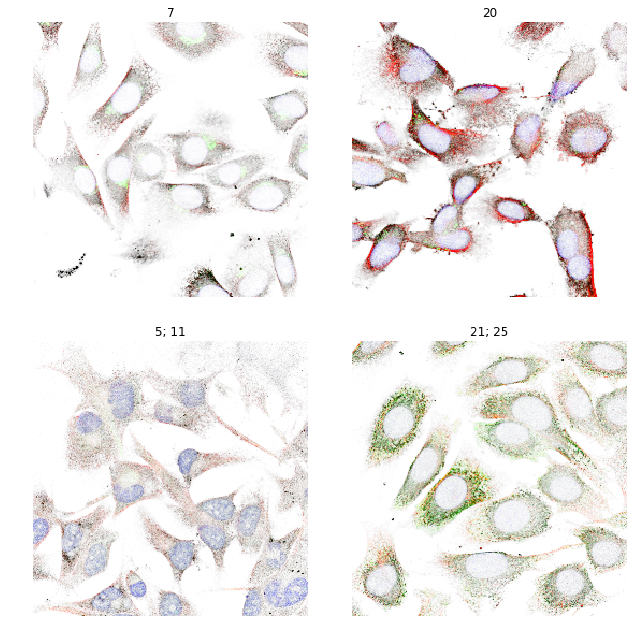

In [18]:
data.show_batch(rows=2, figsize=(9,9), ds_type=DatasetType.Valid)

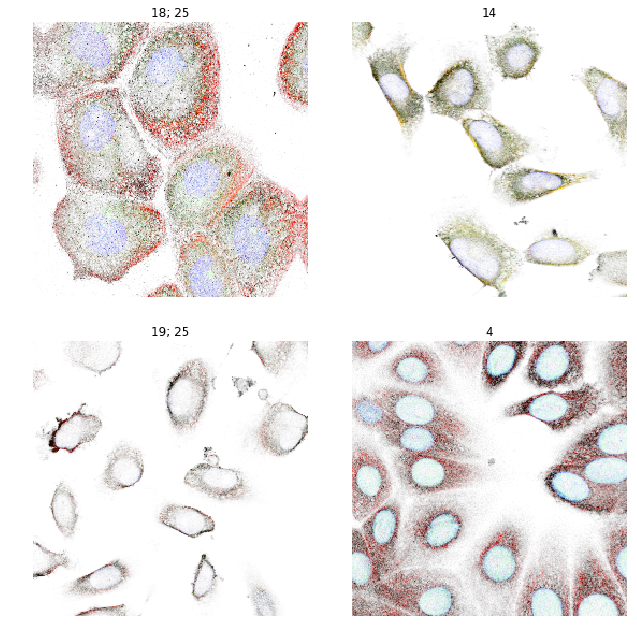

In [19]:
data.show_batch(rows=2, figsize=(9,9))

### create model and learner

In [20]:
weights = torch.tensor([0.5, 0.4, 0.4, 0.4, 0.4, 0.4, 0.4, 0.4, 0.2, 0.2, 0.2, 0.4, 0.4, 0.4, 0.4, 0.2, 0.4, \
                        0.4, 0.4, 0.4, 0.2, 0.4, 0.4, 0.4, 0.4, 0.4, 0.4, 0.2])

#for loss weights: .to(torch.device("cuda"))

In [21]:
f1 = partial(fbeta, thresh=0.4, beta=1) #thresh=weights

In [22]:
def acc(preds,targs,th=0.0):
    preds = (preds > th).int()
    targs = targs.int()
    return (preds==targs).float().mean()

In [23]:
class FocalLoss(nn.Module):
    def __init__(self, gamma=2):
        super().__init__()
        self.gamma = gamma
        
    def forward(self, input, target):
        if not (target.size() == input.size()):
            raise ValueError("Target size ({}) must be the same as input size ({})"
                             .format(target.size(), input.size()))

        max_val = (-input).clamp(min=0)
        loss = input - input * target + max_val + \
            ((-max_val).exp() + (-input - max_val).exp()).log()

        invprobs = F.logsigmoid(-input * (target * 2.0 - 1.0))
        loss = (invprobs * self.gamma).exp() * loss
        
        return loss.sum(dim=1).mean()

In [24]:
def densenet121(pretrained=True):
    return Densenet4Channel(encoder_depth=121, pretrained=pretrained)

def densenet201(pretrained=True):
    return Densenet4Channel(encoder_depth=201, pretrained=pretrained)

In [25]:
def _densenet_split(m:nn.Module): return (m[0][8],m[0][10],m[1])
def _default_split(m:nn.Module): return (m[1],)

In [26]:
@dataclass
class TrackerCallback(LearnerCallback):
    "A `LearnerCallback` that keeps track of the best value in `monitor`."
    monitor:str='val_loss'
    mode:str='auto'
    
    def __post_init__(self):
        if self.mode not in ['auto', 'min', 'max']:
            warn(f'{self.__name__} mode {self.mode} is invalid, falling back to "auto" mode.')
            self.mode = 'auto'
        mode_dict = {'min': np.less, 'max':np.greater}
        mode_dict['auto'] = np.less if 'loss' in self.monitor else np.greater
        self.operator = mode_dict[self.mode]
    
    def on_train_begin(self, **kwargs:Any)->None:
        self.best = float('inf') if self.operator == np.less else -float('inf')
    
    def get_monitor_value(self):
        values = {'trn_loss':self.learn.recorder.losses[-1:][0].cpu().numpy(),
                  'val_loss':self.learn.recorder.val_losses[-1:][0]}
        for i, name in enumerate(self.learn.recorder.names[3:]):
            values[name]=learn.recorder.metrics[-1:][0][i] 
        if values.get(self.monitor) is None:
            warn(f'{self.__name__} conditioned on metric `{self.monitor}` which is not available. Available metrics are: {", ".join(map(str, self.learn.recorder.names[1:]))}')   
        return values.get(self.monitor)

In [27]:
@dataclass
class SaveModel(TrackerCallback):
    "A `LearnerCallback` that saves the model when monitored quantity is best."
    every:str='improvement'
    name:str='bestmodel'
    def __post_init__(self):
        if self.every not in ['improvement', 'epoch']:
            warn(f'SaveModel every {every} is invalid, falling back to "improvement".')
            self.every = 'improvement'
        super().__post_init__()
   
    def on_epoch_end(self, epoch, **kwargs:Any)->None:
        if self.every=="epoch": learn.save(f'{self.name}_{epoch}')
        else: #every="improvement"
            current = self.get_monitor_value()
            if current is not None and self.operator(current, self.best):
                self.best = current
                learn.save(f'{self.name}')
    
    def on_train_end(self, **kwargs):
        if self.every=="improvement": learn.load(f'{self.name}')

In [28]:
learn = create_cnn(
    data,
    densenet201,
    ps=0.5,
    cut=-2,
    split_on=_densenet_split, 
    path=path,    
    metrics=[f1,acc], 
)

/home/dollofcuty/anaconda3/envs/fastai/lib/python3.7/site-packages/torchvision/models/densenet.py:212: UserWarning: nn.init.kaiming_normal is now deprecated in favor of nn.init.kaiming_normal_.
  nn.init.kaiming_normal(m.weight.data)


In [29]:
learn.callback_fns.append(partial(SaveModel, every='improvement', monitor='val_loss'))

In [50]:
learn.loss_func = FocalLoss()

In [51]:
learn.loss_func, learn.opt_func

(FocalLoss(),
 functools.partial(<class 'torch.optim.adam.Adam'>, betas=(0.9, 0.99)))

In [52]:
it = 500
it

500

In [53]:
learn.layer_groups

[Sequential(
   (0): Conv2d(4, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
   (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
   (2): ReLU(inplace)
   (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
   (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
   (5): ReLU(inplace)
   (6): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
   (7): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
   (8): ReLU(inplace)
   (9): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
   (10): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
   (11): ReLU(inplace)
   (12): Conv2d(96, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
   (13): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
   (14): ReLU(inplace)
   (15): Conv2d(128, 32, kernel_s

In [54]:
learn.freeze()

In [55]:
apply_init(learn.model[1], nn.init.kaiming_normal_)

### use lr find to get a good learning rate

In [34]:
learn.data.train_ds, learn.data.valid_ds

(DatasetTfm(ImageMulti4Channel of len 27958),
 DatasetTfm(ImageMulti4Channel of len 3114))

In [39]:
learn.lr_find(num_it=it)

LR Finder complete, type {learner_name}.recorder.plot() to see the graph.


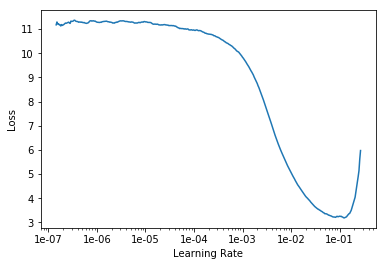

In [40]:
learn.recorder.plot(skip_end=10) 

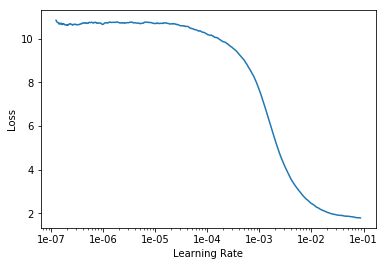

In [39]:
learn.recorder.plot(skip_end=50) #resnet50

In [35]:
lr = 3e-3

### fit the model (half image size)

In [42]:
learn.fit_one_cycle(1, max_lr=slice(lr))

Total time: 07:05
epoch  train_loss  valid_loss  fbeta  acc        
1      1.025063    0.925874    0.559827  0.957542  (07:05)



In [43]:
learn.save('halfsz_focal_dense201_e1')

### unfreeze the densenet layers and train again 

In [31]:
learn.load('halfsz_focal_dense201_e1')

In [32]:
learn.unfreeze()

In [45]:
learn.lr_find(num_it=it)

LR Finder complete, type {learner_name}.recorder.plot() to see the graph.


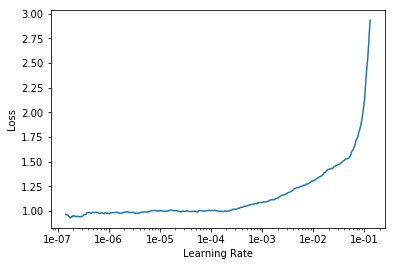

In [46]:
learn.recorder.plot() #densenet201

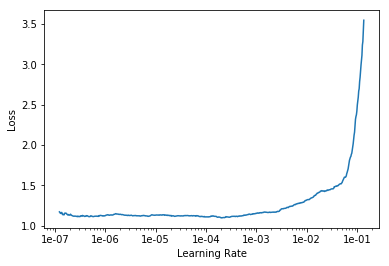

In [45]:
learn.recorder.plot() #densenet121

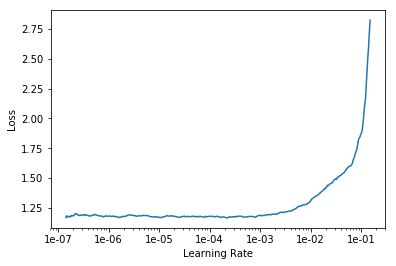

In [38]:
learn.recorder.plot(skip_end=8) #resnet50

In [33]:
#lrs = slice(1e-5, 1e-4) 

In [35]:
lr = 3e-3

In [36]:
lrs = slice(lr/6, lr/3) 

In [37]:
learn.lr_range(lrs)

array([0.0005  , 0.00063 , 0.000794, 0.001   ])

In [38]:
learn.fit_one_cycle(12, max_lr=lrs) #densenet201

Total time: 1:47:18
epoch  train_loss  valid_loss  fbeta  acc        
1      0.964949    0.905192    0.584402  0.958861  (08:43)
2      0.907365    0.827793    0.627941  0.961464  (08:36)
3      0.899807    0.858823    0.614947  0.960157  (08:34)
4      0.868004    0.802011    0.640635  0.961407  (08:35)
5      0.796189    0.748442    0.672482  0.965009  (08:37)
6      0.784906    0.742725    0.669958  0.965249  (08:52)
7      0.738064    0.677992    0.699318  0.967680  (09:22)
8      0.702140    0.654828    0.714704  0.968839  (09:09)
9      0.675352    0.612436    0.731978  0.970559  (09:16)
10     0.634313    0.597143    0.742357  0.971477  (09:13)
11     0.631752    0.589547    0.742492  0.971913  (09:13)
12     0.595761    0.584736    0.745578  0.972039  (09:04)



In [40]:
learn.save('halfsz_focal_dense201_e12')

In [37]:
learn.fit_one_cycle(10, max_lr=lrs) #densenet121

Total time: 51:10
epoch  train_loss  valid_loss  fbeta  acc        
1      0.998076    0.918302    0.569160  0.958024  (05:32)
2      0.892302    0.829354    0.627472  0.961854  (05:05)
3      0.851057    0.821117    0.644680  0.963357  (05:03)
4      0.802128    0.759904    0.664595  0.964859  (05:04)
5      0.735448    0.710872    0.683156  0.966465  (05:03)
6      0.722398    0.657813    0.708512  0.968839  (05:04)
7      0.674804    0.626323    0.725161  0.969940  (05:04)
8      0.634363    0.601315    0.736207  0.971373  (05:04)
9      0.602813    0.589525    0.741939  0.971465  (05:04)
10     0.596430    0.589371    0.740954  0.971316  (05:04)



In [46]:
#learn.fit_one_cycle(10, max_lr=lrs) #resnet50

Total time: 32:18
epoch  train_loss  valid_loss  fbeta  acc        
1      1.088111    1.006122    0.515447  0.954744  (03:19)
2      0.966861    0.920418    0.572221  0.957015  (03:17)
3      0.896537    1.234196    0.482808  0.947404  (03:14)
4      0.849352    0.848208    0.607362  0.959193  (03:16)
5      0.789543    0.819989    0.621616  0.960352  (03:14)
6      0.751200    0.738520    0.660354  0.965157  (03:20)
7      0.706684    0.672656    0.698706  0.967944  (03:12)
8      0.666449    0.640727    0.712659  0.969481  (03:07)
9      0.629019    0.618797    0.724234  0.970525  (03:08)
10     0.617504    0.615692    0.724990  0.970651  (03:08)



### train on whole picture (512px)

In [30]:
bs = 5

In [31]:
data = ImageDataBunch.create(trn_ds, val_ds, test_ds=test_ds, path=path, bs=bs, ds_tfms=(trn_tfms, []), \
                             num_workers=8, size=src_size).normalize(protein_stats)

In [32]:
learn = create_cnn(
    data,
    densenet201,
    ps=0.5,
    cut=-2,
    split_on=_densenet_split, 
    path=path,    
    metrics=[f1,acc], 
)

In [33]:
learn.callback_fns.append(partial(SaveModel, every='improvement', monitor='val_loss'))

In [34]:
learn.loss_func = FocalLoss()

In [35]:
learn.layer_groups

[Sequential(
   (0): Conv2d(4, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
   (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
   (2): ReLU(inplace)
   (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
   (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
   (5): ReLU(inplace)
   (6): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
   (7): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
   (8): ReLU(inplace)
   (9): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
   (10): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
   (11): ReLU(inplace)
   (12): Conv2d(96, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
   (13): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
   (14): ReLU(inplace)
   (15): Conv2d(128, 32, kernel_s

In [31]:
learn.load('halfsz_focal_dense201_e12')

In [38]:
learn.freeze()

In [39]:
learn.lr_find(num_it=500)

LR Finder complete, type {learner_name}.recorder.plot() to see the graph.


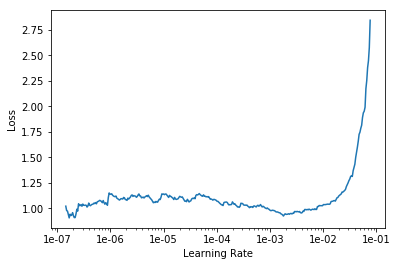

In [40]:
learn.recorder.plot()

In [32]:
lr = 1e-3

In [2]:
learn.fit_one_cycle(1, max_lr=slice(lr))

NameError: name 'learn' is not defined

In [126]:
learn.save('fullsz_focal_dense201_e1')

In [36]:
learn.load('halfsz_focal_dense201_e12')

In [37]:
learn.unfreeze()

In [34]:
#learn.lr_find(num_it=500)

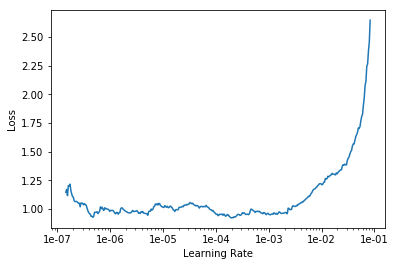

In [34]:
learn.recorder.plot() #densenet201 without frozen training

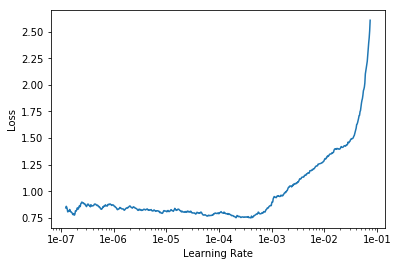

In [42]:
learn.recorder.plot() #densenet121 without frozen training

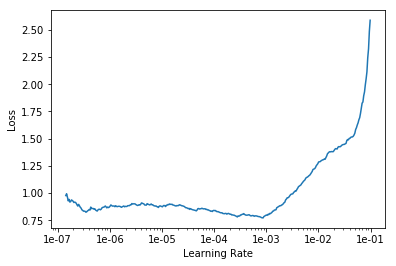

In [49]:
learn.recorder.plot() #resnet50 without frozen training

In [38]:
lr = 1e-3

In [39]:
#lr_fine = lr/3
lrs = slice(lr/9, lr)

In [40]:
learn.lr_range(lrs)

array([0.000111, 0.000231, 0.000481, 0.001   ])

In [42]:
# Densenet 201: overfitting, worse fitting

In [43]:
learn.fit_one_cycle(30, lrs) #lr/20, lr/10 densenet121 lr=1e-3

Total time: 10:28:40
epoch  train_loss  valid_loss  fbeta  acc        
1      0.720509    0.683095    0.702608  0.968059  (21:11)
2      0.652368    0.621992    0.724185  0.970502  (20:49)
3      0.664270    0.629654    0.723165  0.970594  (20:50)
4      0.674156    0.613481    0.735035  0.971041  (20:50)
5      0.626488    0.618893    0.734568  0.971155  (20:50)
6      0.649600    0.610009    0.737465  0.971798  (20:50)
7      0.654941    0.604447    0.737975  0.972211  (20:50)
8      0.613240    0.600463    0.748876  0.972062  (20:50)
9      0.697025    0.612135    0.739178  0.971500  (20:50)
10     0.643987    0.614342    0.735419  0.971798  (20:53)
11     0.653276    0.587993    0.750673  0.972738  (20:54)
12     0.622698    0.605483    0.749621  0.972314  (20:54)
13     0.626032    0.601098    0.732964  0.972188  (20:54)
14     0.659506    0.578467    0.749802  0.972807  (20:53)
15     0.626767    0.593510    0.746742  0.972738  (20:53)
16     0.627735    0.570152    0.752809  0.9

In [52]:
#learn.fit_one_cycle(30, lrs) #lr/20, lr/10 resnet50 compare

Total time: 8:41:23
epoch  train_loss  valid_loss  fbeta  acc        
1      0.660707    0.662754    0.702907  0.968598  (17:30)
2      0.658712    0.621468    0.719857  0.970399  (17:24)
3      0.631526    0.601416    0.730012  0.971190  (17:20)
4      0.644306    0.592997    0.741107  0.972004  (17:22)
5      0.655353    0.597178    0.739216  0.971087  (17:22)
6      0.618391    0.584602    0.740991  0.971959  (17:22)
7      0.620989    0.593008    0.734230  0.971752  (17:22)
8      0.616385    0.586004    0.745648  0.972394  (17:22)
9      0.612414    0.591006    0.737570  0.972463  (17:22)
10     0.645932    0.589050    0.743536  0.972337  (17:22)
11     0.627647    0.588514    0.744913  0.971637  (17:22)
12     0.570436    0.573974    0.744113  0.973082  (17:22)
13     0.602325    0.575472    0.750654  0.973117  (17:21)
14     0.572829    0.565462    0.755961  0.973874  (17:22)
15     0.585624    0.561532    0.756438  0.973667  (17:22)
16     0.538708    0.550453    0.758691  0.97

In [32]:
learn.load('fullsz_focal_dense201_e30')

In [33]:
learn.unfreeze()

In [42]:
lrs = slice(lr_fine/2, lr_fine)

In [43]:
learn.lr_range(lrs)

array([5.000000e-05, 6.299605e-05, 7.937005e-05, 1.000000e-04])

In [45]:
#learn.fit_one_cycle(10, lrs) #lr/20, lr/10 densenet

In [ ]:
learn.save('fullsz_focal_dense201_e40')

### Try to find a good Threshold

In [46]:
learn.load('fullsz_focal_dense201_e30')

In [47]:
learn.model.eval()

Sequential(
  (0): Sequential(
    (0): Conv2d(4, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): _DenseBlock(
      (denselayer1): _DenseLayer(
        (norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): ReLU(inplace)
        (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (norm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu2): ReLU(inplace)
        (conv2): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      )
      (denselayer2): _DenseLayer(
        (norm1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): ReLU(inplace)
        (conv1): Conv2d(96, 

In [48]:
preds, y = learn.get_preds(DatasetType.Valid)

In [49]:
preds_tta,y = learn.TTA(ds_type=DatasetType.Valid)

Total time: 05:43



In [50]:
preds.shape, preds_tta.shape

(torch.Size([3114, 28]), torch.Size([3114, 28]))

In [51]:
#m = nn.Softmax(dim=1)
#act_preds = m(preds)

In [52]:
#act_preds = np.exp(preds)

In [53]:
act_preds = torch.sigmoid(preds)

act_preds_tta = torch.sigmoid(preds_tta)

In [54]:
#np.set_printoptions(suppress=True)

In [55]:
act_preds[0].round(), y[0]

(tensor([0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]),
 tensor([0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]))

In [56]:
act_preds.shape, act_preds_tta.shape

(torch.Size([3114, 28]), torch.Size([3114, 28]))

In [101]:
ensamble = act_preds * 0.1 + act_preds_tta * 0.9

In [102]:
fbeta(ensamble, y, thresh=0.34, sigmoid=False) 

tensor(0.8151)

In [477]:
fbeta(ensamble, y, thresh=0.34, sigmoid=False) #compare

tensor(0.8251)

### predict test set 

In [63]:
preds_t,y_t = learn.get_preds(DatasetType.Test)

In [64]:
preds_t_tta,y_t = learn.TTA(ds_type=DatasetType.Test)

Total time: 19:59



In [65]:
#m = nn.Softmax(dim=1)
#act_preds_t = m(preds_t)

In [66]:
#act_preds_t = np.exp(preds_t)

In [67]:
act_preds_t = torch.sigmoid(preds_t)

act_preds_t_tta = torch.sigmoid(preds_t_tta)

In [68]:
act_preds_t[0].round(), act_preds_t_tta[0].round()

(tensor([0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]),
 tensor([0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]))

In [69]:
act_preds_t.shape, act_preds_t_tta.shape

(torch.Size([11702, 28]), torch.Size([11702, 28]))

In [80]:
tuned_weights = weights*0.85
tuned_weights

tensor([0.4250, 0.3400, 0.3400, 0.3400, 0.3400, 0.3400, 0.3400, 0.3400, 0.1700,
        0.1700, 0.1700, 0.3400, 0.3400, 0.3400, 0.3400, 0.1700, 0.3400, 0.3400,
        0.3400, 0.3400, 0.1700, 0.3400, 0.3400, 0.3400, 0.3400, 0.3400, 0.3400,
        0.1700])

In [81]:
ensamble_t = act_preds_t * 0.1 + act_preds_t_tta * 0.9

In [82]:
#preact_preds_td_labels = [' '.join(list([str(i) for i in np.nonzero(row>0.318)[0]])) \
#               for row in np.array(act_preds_t)]

pred_labels = [' '.join(list([str(i) for i in np.nonzero(row>(tuned_weights).numpy())[0]])) \
               for row in np.array(ensamble_t)]

In [83]:
sub = pd.DataFrame({'Id':test_ids,'Predicted':pred_labels})

In [84]:
len(sub['Predicted'][sub['Predicted']=='']) #127 with res50

18

In [85]:
unique_target = df.groupby('Target')['Id'].nunique()

In [86]:
unique_target[unique_target>1000]

Target
0       2414
21      1058
23      1653
25      1470
25 0    1998
4       1077
7       1163
Name: Id, dtype: int64

In [87]:
sub['Predicted'][sub['Predicted']==''] = '0'

In [88]:
sub.to_csv(path/'densenet.csv', header=True, index=False)

In [89]:
pred_labels

['2',
 '5 25',
 '0 5 25',
 '0 25',
 '20 25',
 '4',
 '0 4 21 25',
 '0 23 25',
 '0 25',
 '25',
 '5 18 25',
 '3 5',
 '2 25',
 '7 20 25',
 '23 25',
 '2 25',
 '2 14 25',
 '0 5',
 '14 21',
 '5',
 '1 6 25',
 '20 25',
 '0 25',
 '0 21',
 '0 4 25',
 '0 21 23 25',
 '0 21 25',
 '0 1',
 '0 25',
 '5',
 '13 21 25',
 '0 19',
 '17 18',
 '5 25',
 '0 7 25',
 '13',
 '25',
 '0 3',
 '0 21 25',
 '1',
 '0 21 25',
 '6',
 '0 25',
 '19 25',
 '25',
 '20',
 '0',
 '0 5',
 '0 6 25',
 '5',
 '25',
 '0 5',
 '20',
 '25',
 '3',
 '0 25',
 '0 25',
 '11 25',
 '0 25',
 '21 25',
 '2 20',
 '0 5 21 25',
 '14 25',
 '21 25',
 '7 23 25',
 '0 25',
 '3 21 25',
 '25',
 '0 25',
 '25',
 '2',
 '0 2 25',
 '14',
 '4',
 '21 25',
 '0',
 '4',
 '0 1',
 '0 25',
 '0 25',
 '0 5 25',
 '0 25',
 '4 21 25',
 '21 25',
 '18',
 '0 24 25',
 '23',
 '0 21',
 '25',
 '14 25',
 '25',
 '11 21',
 '23',
 '13',
 '23 25',
 '0 25',
 '7 19 25',
 '0 7 25',
 '24',
 '0 23 25',
 '0 11 25',
 '23',
 '11 23',
 '0 23',
 '7 25',
 '21 25',
 '0 14 16 25',
 '0 11 25',
 '20 26'